# 获取遥感影像

遥感影像数据量大且多，无法逐一下载后进行处理。

这个文档里提供的方法展示了如何利用 stac + stackstac 在线获取常用的遥感影像（如Sentinel或Landsat）数据并写入到xarray中

In [1]:
from typing import Any, List, Optional, Union

import numpy as np
import pandas as pd
import planetary_computer as pc
import pystac_client
import rasterio.features
import stackstac
import xarray as xr

from utils import from_latlon, from_points

## Sentinel影像

In [14]:
lat=38.87962 # Central latitude of the cube
lon=121.52412 # Central longitude of the cube

collection = "sentinel-s2-l2a-cogs"  # Name of the STAC collection
# collection="landsat-c2-l2" # Name of the STAC collection

bands = ["B02", "B03", "B04"]  # Bands to retrieve
# bands=["OLI_B2","OLI_B3","OLI_B4"] # Bands to retrieve

start_date = "2020-04-01"  # Start date of the cube
end_date = "2020-04-02"  # End date of the cube
edge_size = 256
resolution = 10
# stac = "https://planetarycomputer.microsoft.com/api/stac/v1"
stac = "https://earth-search.aws.element84.com/v0"

In [15]:
# Get the BBox and EPSG
bbox_utm, bbox_latlon, utm_coords, epsg = from_latlon(
    lat, lon, edge_size, resolution
)
bbox_utm, bbox_latlon, utm_coords, epsg

({'type': 'Polygon',
  'coordinates': [[[371480, 4303950],
    [372480, 4303950],
    [372480, 4304950],
    [371480, 4304950],
    [371480, 4303950]]]},
 {'type': 'Polygon',
  'coordinates': [[[121.51843247841738, 38.87501470543508],
    [121.5299568464628, 38.87516037146228],
    [121.52977118575822, 38.88416894137354],
    [121.51824536352318, 38.884023228767944],
    [121.51843247841738, 38.87501470543508]]]},
 (371981.6578339997, 4304453.08626435),
 'EPSG:32651')

In [16]:
# Convert UTM Bbox to a Feature
bbox_utm = rasterio.features.bounds(bbox_utm)
bbox_utm

(371480, 4303950, 372480, 4304950)

In [17]:
# Open the Catalogue
CATALOG = pystac_client.Client.open(stac)

In [18]:
# Do a search
SEARCH = CATALOG.search(
    intersects=bbox_latlon,
    datetime=f"{start_date}/{end_date}",
    collections=[collection],
    # **kwargs,
)

In [19]:
# Get all items and sign if using Planetary Computer
items = SEARCH.get_all_items()
items

ID: S2B_51SUD_20200401_0_L2A
"Bounding Box: [120.66637913217698, 38.73821881877811, 121.96019795622675, 39.745484430665385]"
Datetime: 2020-04-01 02:56:48+00:00
created: 2020-08-19T00:44:18.789Z
sentinel:product_id: S2B_MSIL2A_20200401T024549_N0214_R132_T51SUD_20200401T050434
sentinel:sequence: 0
view:off_nadir: 0
sentinel:valid_cloud_cover: True
platform: sentinel-2b
sentinel:utm_zone: 51
proj:epsg: 32651


In [20]:
# Put the bands into list if not a list already
if not isinstance(bands, list) and bands is not None:
    bands = [bands]
bands

['B02', 'B03', 'B04']

In [21]:
# Create the stack
sk = stackstac.stack(
    items,
    assets=bands,
    resolution=resolution,
    bounds=bbox_utm,
    epsg=epsg,
)
sk

<xarray.DataArray 'stackstac-ed46079a44e6ce2f90a33a6d489e7df0' (time: 1,
                                                                band: 3,
                                                                y: 100, x: 100)>
dask.array<fetch_raster_window, shape=(1, 3, 100, 100), dtype=float64, chunksize=(1, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/25)
  * time                        (time) datetime64[ns] 2020-04-01T02:56:48
    id                          (time) <U24 'S2B_51SUD_20200401_0_L2A'
  * band                        (band) <U3 'B02' 'B03' 'B04'
  * x                           (x) float64 3.715e+05 3.715e+05 ... 3.725e+05
  * y                           (y) float64 4.305e+06 4.305e+06 ... 4.304e+06
    view:off_nadir              int64 0
    ...                          ...
    instruments                 <U3 'msi'
    created                     <U24 '2020-08-19T00:44:18.789Z'
    title                       (band) <U14 'Band 2 (blue)' ... 'Band 4 (red)'
    proj:transform              object {0, 300000, 1, 4400040, 10, -10}
    proj:shape                  object {10980}
    epsg                        <U10 'EPSG:32651'
Attributes:
    spec:        RasterSpec(epsg='EPSG:32651', bounds=(371480, 4303950, 37248...
    crs:         epsg:EPSG:32651
    transform:   | 10.00, 0.00, 371480.00|\n| 0.00,-10.00, 4304950.00|\n| 0.0...
    resolution:  10

In [22]:
# Delete attributes
attributes = ["spec", "crs", "transform", "resolution"]

for attribute in attributes:
    if attribute in sk.attrs:
        del sk.attrs[attribute]

In [23]:
# New attributes
sk.attrs = dict(
    collection=collection,
    stac=stac,
    epsg=epsg,
    resolution=resolution,
    edge_size=edge_size,
    central_lat=lat,
    central_lon=lon,
    central_y=utm_coords[1],
    central_x=utm_coords[0],
    time_coverage_start=start_date,
    time_coverage_end=end_date,
)
sk

<xarray.DataArray 'stackstac-ed46079a44e6ce2f90a33a6d489e7df0' (time: 1,
                                                                band: 3,
                                                                y: 100, x: 100)>
dask.array<fetch_raster_window, shape=(1, 3, 100, 100), dtype=float64, chunksize=(1, 1, 100, 100), chunktype=numpy.ndarray>
Coordinates: (12/25)
  * time                        (time) datetime64[ns] 2020-04-01T02:56:48
    id                          (time) <U24 'S2B_51SUD_20200401_0_L2A'
  * band                        (band) <U3 'B02' 'B03' 'B04'
  * x                           (x) float64 3.715e+05 3.715e+05 ... 3.725e+05
  * y                           (y) float64 4.305e+06 4.305e+06 ... 4.304e+06
    view:off_nadir              int64 0
    ...                          ...
    instruments                 <U3 'msi'
    created                     <U24 '2020-08-19T00:44:18.789Z'
    title                       (band) <U14 'Band 2 (blue)' ... 'Band 4 (red)'
    proj:transform              object {0, 300000, 1, 4400040, 10, -10}
    proj:shape                  object {10980}
    epsg                        <U10 'EPSG:32651'
Attributes:
    collection:           sentinel-s2-l2a-cogs
    stac:                 https://earth-search.aws.element84.com/v0
    epsg:                 EPSG:32651
    resolution:           10
    edge_size:            100
    central_lat:          38.87962
    central_lon:          121.52412
    central_y:            4304453.08626435
    central_x:            371981.6578339997
    time_coverage_start:  2020-04-01
    time_coverage_end:    2020-04-02

In [24]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = sk.compute()

[########################################] | 100% Completed |  3.7s


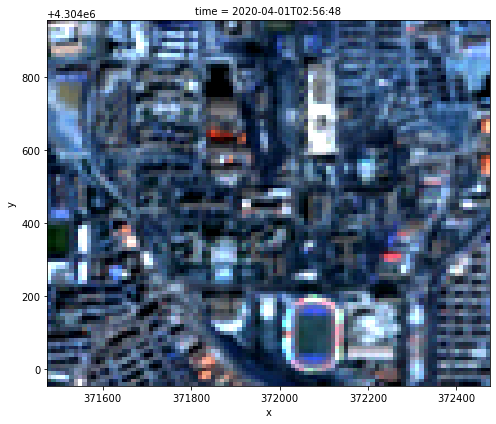

In [25]:
data.plot.imshow(row="time", rgb="band", robust=True, size=6);

## Microsoft Planetary Computer

In [54]:
lat = 38.87962  # Central latitude of the cube
lon = 121.52412  # Central longitude of the cube

collection = "sentinel-2-l2a"  # Name of the STAC collection
# collection="landsat-c2-l2" # Name of the STAC collection

# bands=["OLI_B2","OLI_B3","OLI_B4"] # Bands to retrieve

start_date = "2022-04-03"  # Start date of the cube
end_date = "2022-04-04"  # End date of the cube
edge_size = 256
resolution = 10
stac = "https://planetarycomputer.microsoft.com/api/stac/v1"
# stac = "https://earth-search.aws.element84.com/v0"

In [55]:
# Get the BBox and EPSG
bbox_utm, bbox_latlon, utm_coords, epsg = from_latlon(
    lat, lon, edge_size, resolution
)
bbox_utm, bbox_latlon, utm_coords, epsg

({'type': 'Polygon',
  'coordinates': [[[370700, 4303170],
    [373260, 4303170],
    [373260, 4305730],
    [370700, 4305730],
    [370700, 4303170]]]},
 {'type': 'Polygon',
  'coordinates': [[[121.50959030527913, 38.86787366691564],
    [121.53908978451993, 38.86824647894349],
    [121.53861739689025, 38.89130851027759],
    [121.50910838747232, 38.890935392993626],
    [121.50959030527913, 38.86787366691564]]]},
 (371981.6578339997, 4304453.08626435),
 'EPSG:32651')

In [56]:
# Convert UTM Bbox to a Feature
bbox_utm = rasterio.features.bounds(bbox_utm)
bbox_utm

(370700, 4303170, 373260, 4305730)

In [57]:
# Open the Catalogue
CATALOG = pystac_client.Client.open(stac)

In [58]:
# Do a search
SEARCH = CATALOG.search(
    intersects=bbox_latlon,
    datetime=f"{start_date}/{end_date}",
    collections=[collection],
    # **kwargs,
)

In [71]:
# Get all items and sign if using Planetary Computer
items = SEARCH.get_all_items()
items

ID: S2A_MSIL2A_20220403T023551_R089_T51SUD_20220403T110250
"Bounding Box: [120.93402044, 38.74156879, 121.96189511, 39.74549355]"
Datetime: 2022-04-03 02:35:51.024000+00:00
datetime: 2022-04-03T02:35:51.024000Z
platform: Sentinel-2A
proj:epsg: 32651
instruments: ['msi']
s2:mgrs_tile: 51SUD
constellation: Sentinel 2
s2:granule_id: S2A_OPER_MSI_L2A_TL_ESRI_20220403T110250_A035407_T51SUD_N04.00
eo:cloud_cover: 3.806667


In [72]:
items = pc.sign(items)

In [73]:
# Put the bands into list if not a list already
if not isinstance(bands, list) and bands is not None:
    bands = [bands]
bands

['B02', 'B03', 'B04']

In [74]:
# Create the cube
cube = stackstac.stack(
    items,
    assets=bands,
    resolution=resolution,
    bounds=bbox_utm,
    epsg=epsg,
)
cube

<xarray.DataArray 'stackstac-9ee62e2aee55040e895e2dc66a4ccdcd' (time: 1,
                                                                band: 3,
                                                                y: 256, x: 256)>
dask.array<fetch_raster_window, shape=(1, 3, 256, 256), dtype=float64, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2022-04-03...
    id                                       (time) <U54 'S2A_MSIL2A_20220403...
  * band                                     (band) <U3 'B02' 'B03' 'B04'
  * x                                        (x) float64 3.707e+05 ... 3.732e+05
  * y                                        (y) float64 4.306e+06 ... 4.303e+06
    s2:generation_time                       <U26 '2022-04-03T11:02:50.94227Z'
    ...                                       ...
    proj:bbox                                object {300000.0, 409800.0, 4400...
    proj:shape                               object {10980}
    common_name                              (band) <U5 'blue' 'green' 'red'
    center_wavelength                        (band) float64 0.49 0.56 0.665
    full_width_half_max                      (band) float64 0.098 0.045 0.038
    epsg                                     <U10 'EPSG:32651'
Attributes:
    spec:        RasterSpec(epsg='EPSG:32651', bounds=(370700, 4303170, 37326...
    crs:         epsg:EPSG:32651
    transform:   | 10.00, 0.00, 370700.00|\n| 0.00,-10.00, 4305730.00|\n| 0.0...
    resolution:  10

In [75]:
# Delete attributes
attributes = ["spec", "crs", "transform", "resolution"]

for attribute in attributes:
    if attribute in cube.attrs:
        del cube.attrs[attribute]

In [76]:
# New attributes
cube.attrs = dict(
    collection=collection,
    stac=stac,
    epsg=epsg,
    resolution=resolution,
    edge_size=edge_size,
    central_y=utm_coords[1],
    central_x=utm_coords[0],
    time_coverage_start=start_date,
    time_coverage_end=end_date,
)
cube

<xarray.DataArray 'stackstac-9ee62e2aee55040e895e2dc66a4ccdcd' (time: 1,
                                                                band: 3,
                                                                y: 256, x: 256)>
dask.array<fetch_raster_window, shape=(1, 3, 256, 256), dtype=float64, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2022-04-03...
    id                                       (time) <U54 'S2A_MSIL2A_20220403...
  * band                                     (band) <U3 'B02' 'B03' 'B04'
  * x                                        (x) float64 3.707e+05 ... 3.732e+05
  * y                                        (y) float64 4.306e+06 ... 4.303e+06
    s2:generation_time                       <U26 '2022-04-03T11:02:50.94227Z'
    ...                                       ...
    proj:bbox                                object {300000.0, 409800.0, 4400...
    proj:shape                               object {10980}
    common_name                              (band) <U5 'blue' 'green' 'red'
    center_wavelength                        (band) float64 0.49 0.56 0.665
    full_width_half_max                      (band) float64 0.098 0.045 0.038
    epsg                                     <U10 'EPSG:32651'
Attributes:
    collection:           sentinel-2-l2a
    stac:                 https://planetarycomputer.microsoft.com/api/stac/v1
    epsg:                 EPSG:32651
    resolution:           10
    edge_size:            256
    central_y:            4304453.08626435
    central_x:            371981.6578339997
    time_coverage_start:  2022-04-03
    time_coverage_end:    2022-04-04

In [77]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = cube.compute()

[########################################] | 100% Completed |  3.2s


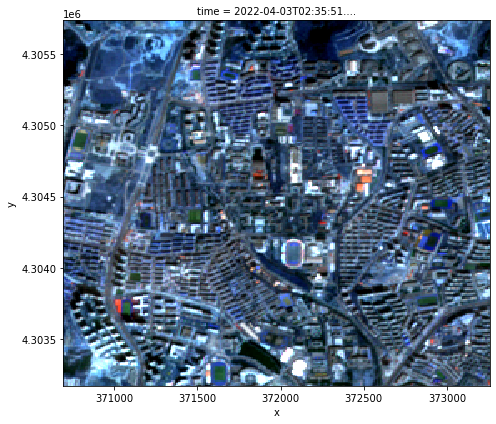

In [78]:
data.plot.imshow(row="time", rgb="band", robust=True, size=6);

## Landsat影像

In [209]:
lat=38.87962 # Central latitude of the cube
lon=121.52412 # Central longitude of the cube

collection="landsat-c2-l2" # Name of the STAC collection

# bands=["OLI_B2","OLI_B3","OLI_B4"] # Bands to retrieve
bands=["blue","red","nir08"] # Bands to retrieve

start_date = "2021-06-30"  # Start date of the cube
end_date = "2021-07-31"  # End date of the cube
edge_size = 256
resolution = 30
stac = "https://planetarycomputer.microsoft.com/api/stac/v1"

In [210]:
# Get the BBox and EPSG
bbox_utm, bbox_latlon, utm_coords, epsg = from_latlon(
    lat, lon, edge_size, resolution
)
bbox_utm, bbox_latlon, utm_coords, epsg

({'type': 'Polygon',
  'coordinates': [[[368130, 4300620],
    [375810, 4300620],
    [375810, 4308300],
    [368130, 4308300],
    [368130, 4300620]]]},
 {'type': 'Polygon',
  'coordinates': [[[121.4804651539524, 38.844520481108994],
    [121.56893512805945, 38.845638092378564],
    [121.56754643915873, 38.914825079245155],
    [121.47899069309805, 38.91370472045013],
    [121.4804651539524, 38.844520481108994]]]},
 (371981.6578339997, 4304453.08626435),
 'EPSG:32651')

In [211]:
# Convert UTM Bbox to a Feature
bbox_utm = rasterio.features.bounds(bbox_utm)
bbox_utm

(368130, 4300620, 375810, 4308300)

In [212]:
# Open the Catalogue
CATALOG = pystac_client.Client.open(stac)

In [213]:
# Do a search
SEARCH = CATALOG.search(
    intersects=bbox_latlon,
    datetime=f"{start_date}/{end_date}",
    collections=[collection],
    query={"eo:cloud_cover": {"lt": 10}},
)

In [214]:
# Get all items and sign if using Planetary Computer
items = SEARCH.get_all_items()
items

ID: LC08_L2SP_119033_20210725_02_T1
"Bounding Box: [121.09050962, 37.81931491, 123.81628555, 39.96431509]"
Datetime: 2021-07-25 02:29:11.792979+00:00
gsd: 30
created: 2022-05-06T17:01:14.205023Z
sci:doi: 10.5066/P9OGBGM6
datetime: 2021-07-25T02:29:11.792979Z
platform: landsat-8
proj:epsg: 32651
"proj:shape: [7891, 7761]"
description: Landsat Collection 2 Level-2


In [215]:
items = pc.sign(items)

In [216]:
# Put the bands into list if not a list already
if not isinstance(bands, list) and bands is not None:
    bands = [bands]
bands

['blue', 'red', 'nir08']

In [217]:
# Create the stack
sk = stackstac.stack(
    items,
    assets=bands,
    resolution=resolution,
    bounds=bbox_utm,
    epsg=epsg,
)
sk

<xarray.DataArray 'stackstac-6b8deaee5b1fcd5ad78ad27a294120c5' (time: 1,
                                                                band: 3,
                                                                y: 256, x: 256)>
dask.array<fetch_raster_window, shape=(1, 3, 256, 256), dtype=float64, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/32)
  * time                         (time) datetime64[ns] 2021-07-25T02:29:11.79...
    id                           (time) <U31 'LC08_L2SP_119033_20210725_02_T1'
  * band                         (band) <U5 'blue' 'red' 'nir08'
  * x                            (x) float64 3.681e+05 3.682e+05 ... 3.758e+05
  * y                            (y) float64 4.308e+06 4.308e+06 ... 4.301e+06
    sci:doi                      <U16 '10.5066/P9OGBGM6'
    ...                           ...
    title                        (band) <U22 'Blue Band' ... 'Near Infrared B...
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    common_name                  (band) <U5 'blue' 'red' 'nir08'
    center_wavelength            (band) float64 0.48 0.65 0.87
    full_width_half_max          (band) float64 0.06 0.04 0.03
    epsg                         <U10 'EPSG:32651'
Attributes:
    spec:        RasterSpec(epsg='EPSG:32651', bounds=(368130, 4300620, 37581...
    crs:         epsg:EPSG:32651
    transform:   | 30.00, 0.00, 368130.00|\n| 0.00,-30.00, 4308300.00|\n| 0.0...
    resolution:  30

In [218]:
# Delete attributes
attributes = ["spec", "crs", "transform", "resolution"]

for attribute in attributes:
    if attribute in sk.attrs:
        del sk.attrs[attribute]

In [219]:
# New attributes
sk.attrs = dict(
    collection=collection,
    stac=stac,
    epsg=epsg,
    resolution=resolution,
    edge_size=edge_size,
    central_lat=lat,
    central_lon=lon,
    central_y=utm_coords[1],
    central_x=utm_coords[0],
    time_coverage_start=start_date,
    time_coverage_end=end_date,
)
sk

<xarray.DataArray 'stackstac-6b8deaee5b1fcd5ad78ad27a294120c5' (time: 1,
                                                                band: 3,
                                                                y: 256, x: 256)>
dask.array<fetch_raster_window, shape=(1, 3, 256, 256), dtype=float64, chunksize=(1, 1, 256, 256), chunktype=numpy.ndarray>
Coordinates: (12/32)
  * time                         (time) datetime64[ns] 2021-07-25T02:29:11.79...
    id                           (time) <U31 'LC08_L2SP_119033_20210725_02_T1'
  * band                         (band) <U5 'blue' 'red' 'nir08'
  * x                            (x) float64 3.681e+05 3.682e+05 ... 3.758e+05
  * y                            (y) float64 4.308e+06 4.308e+06 ... 4.301e+06
    sci:doi                      <U16 '10.5066/P9OGBGM6'
    ...                           ...
    title                        (band) <U22 'Blue Band' ... 'Near Infrared B...
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    common_name                  (band) <U5 'blue' 'red' 'nir08'
    center_wavelength            (band) float64 0.48 0.65 0.87
    full_width_half_max          (band) float64 0.06 0.04 0.03
    epsg                         <U10 'EPSG:32651'
Attributes:
    collection:           landsat-c2-l2
    stac:                 https://planetarycomputer.microsoft.com/api/stac/v1
    epsg:                 EPSG:32651
    resolution:           30
    edge_size:            256
    central_lat:          38.87962
    central_lon:          121.52412
    central_y:            4304453.08626435
    central_x:            371981.6578339997
    time_coverage_start:  2021-06-30
    time_coverage_end:    2021-07-31

In [220]:
import dask.diagnostics
with dask.diagnostics.ProgressBar():
    data = sk.compute()

[########################################] | 100% Completed |  3.3s


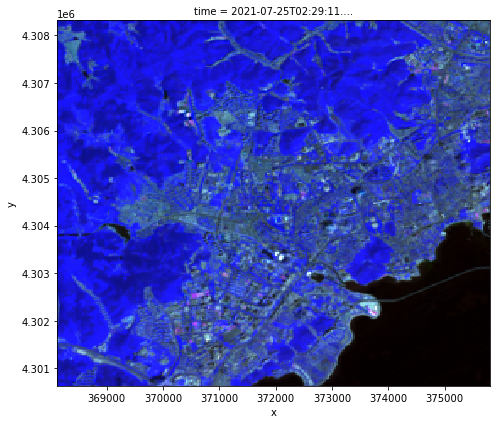

In [221]:
data.plot.imshow(row="time", rgb="band", robust=True, size=6);